# Timeseries

This notebook is part of the course called [Effective Pandas](https://github.com/TomAugspurger/effective-pandas).

Pandas started out in the financial world, so naturally it has strong timeseries support.



In [9]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's grab some stock data for Goldman Sachs:

In [16]:
gs = pd.read_csv('sample_data.csv', index_col=['Date'], parse_dates=True, infer_datetime_format=True)
gs.head().round(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.70,129.44,124.23,128.87,110.91,6188700
2006-01-04,127.35,128.91,126.38,127.09,109.38,4861600
2006-01-05,126.00,127.32,125.61,127.04,109.34,3717400
2006-01-06,127.29,129.25,127.29,128.84,110.89,4319600
2006-01-09,128.50,130.62,128.00,130.39,112.22,4723500


There isn't a special data-container just for time series in pandas, they're just `Series` or `DataFrame`s with a `DatetimeIndex`.

## Special Slicing

Looking at the elements of `gs.index`, we see that `DatetimeIndex`es are made up of `pandas.Timestamp`s:

In [17]:
gs.index[0]

Timestamp('2006-01-03 00:00:00')

A `Timestamp` is mostly compatible with the `datetime.datetime` class, but much amenable to storage in arrays.

Working with `Timestamp`s can be awkward, so Series and DataFrames with `DatetimeIndexes` have some special slicing rules.
The first special case is *partial-string indexing*. Say we wanted to select all the days in 2006. Even with `Timestamp`'s convenient constructors, it's a pai

In [18]:
gs.loc[pd.Timestamp('2006-01-01'):pd.Timestamp('2006-12-31')].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,110.911774,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,109.379845,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,109.336800,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,110.885956,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,112.219994,4723500


Thanks to partial-string indexing, it's as simple as

In [19]:
gs.loc['2006'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,110.911774,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,109.379845,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,109.336800,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,110.885956,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,112.219994,4723500


Since label slicing is inclusive, this slice selects any observation where the year is 2006.

The second "convenience" is `__getitem__` (square-bracket) fall-back indexing. I'm only going to mention it here, with the caveat that you should never use it.
DataFrame `__getitem__` typically looks in the column: `gs['2006']` would search `gs.columns` for `'2006'`, not find it, and raise a `KeyError`. But DataFrames with a `DatetimeIndex` catch that `KeyError` and try to slice the index.
If it succeeds in slicing the index, the result like `gs.loc['2006']` is returned.
If it fails, the `KeyError` is re-raised.
This is confusing because in pretty much every other case `DataFrame.__getitem__` works on columns, and it's fragile because if you happened to have a column `'2006'` you *would* get just that column, and no fall-back indexing would occur. Just use `gs.loc['2006']` when slicing DataFrame indexes.


## Special Methods

### Resampling

Resampling is similar to a `groupby`: you split the time series into groups (5-day buckets below), apply a function to each group (`mean`), and combine the result (one row per group).

In [20]:
gs.resample("5d").mean().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.834999,128.730002,125.877501,127.959997,110.128594,4.771825e+06
2006-01-08,130.349998,132.645000,130.205002,131.660000,113.313015,4.664300e+06
2006-01-13,131.510002,133.395004,131.244995,132.924996,114.401707,3.258250e+06
2006-01-18,132.210002,133.853333,131.656667,132.543335,114.143812,4.997767e+06
2006-01-23,133.771997,136.083997,133.310001,135.153998,116.537834,3.968500e+06


In [21]:
gs.resample("W").agg(['mean', 'sum']).head()

Open                    High                     Low  \
                  mean         sum        mean         sum        mean   
Date                                                                     
2006-01-08  126.834999  507.339996  128.730002  514.920006  125.877501   
2006-01-15  130.684000  653.419998  132.848001  664.240006  130.544000   
2006-01-22  131.907501  527.630005  133.672501  534.690003  131.390000   
2006-01-29  133.771997  668.859986  136.083997  680.419983  133.310001   
2006-02-05  140.900000  704.500000  142.467999  712.339996  139.937998   

                             Close               Adj Close              \
                   sum        mean         sum        mean         sum   
Date                                                                     
2006-01-08  503.510002  127.959997  511.839988  110.128594  440.514375   
2006-01-15  652.720001  131.979999  659.899994  113.588417  567.942086   
2006-01-22  525.559998  132.555000  530.220000  114.136206  456.544823   
2006-01-29  666.550003  135.153998  675.769989  116.537834  582.689171   
2006-02-05  699.689988  141.618002  708.090011  122.111458  610.557289   

               Volume            
                 mean       sum  
Date                             
2006-01-08  4771825.0  19087300  
2006-01-15  4310420.0  21552100  
2006-01-22  4653725.0  18614900  
2006-01-29  3968500.0  19842500  
2006-02-05  3920120.0  19600600

You can up-sample to convert to a higher frequency.
The new points are filled with NaNs.

In [22]:
gs.resample("6H").mean().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03 00:00:00,126.699997,129.440002,124.230003,128.869995,110.911774,6188700.0
2006-01-03 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04 00:00:00,127.349998,128.910004,126.379997,127.089996,109.379845,4861600.0


### Rolling / Expanding / EW

These methods aren't unique to `DatetimeIndex`es, but they often make sense with time series, so I'll show them here.

Text(95.875,0.5,'Close ($)')

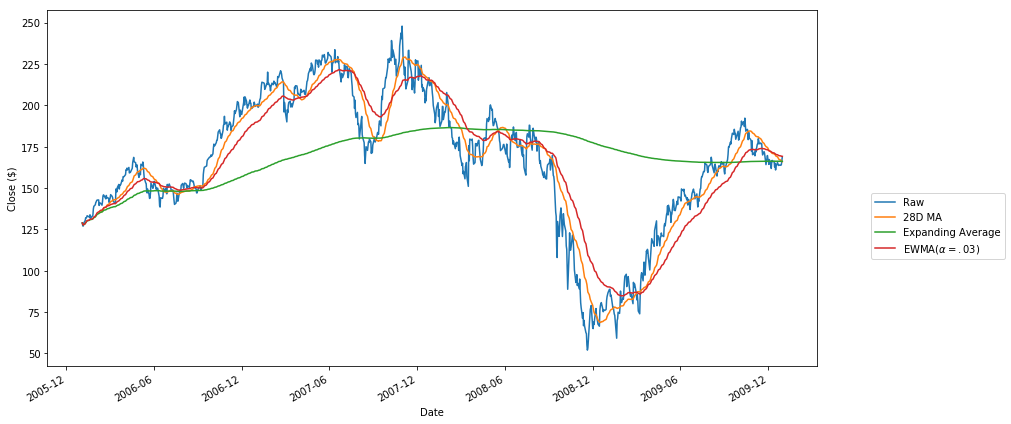

In [25]:
gs.Close.plot(label='Raw', figsize=(14, 6))
gs.Close.rolling(28).mean().plot(label='28D MA')
gs.Close.expanding().mean().plot(label='Expanding Average')
gs.Close.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")

Each of `.rolling`, `.expanding`, and `.ewm` return a deferred object, similar to a GroupBy.

In [26]:
roll = gs.Close.rolling(30, center=True)
roll

Rolling [window=30,center=True,axis=0]

Text(95.875,0.5,'Close ($)')

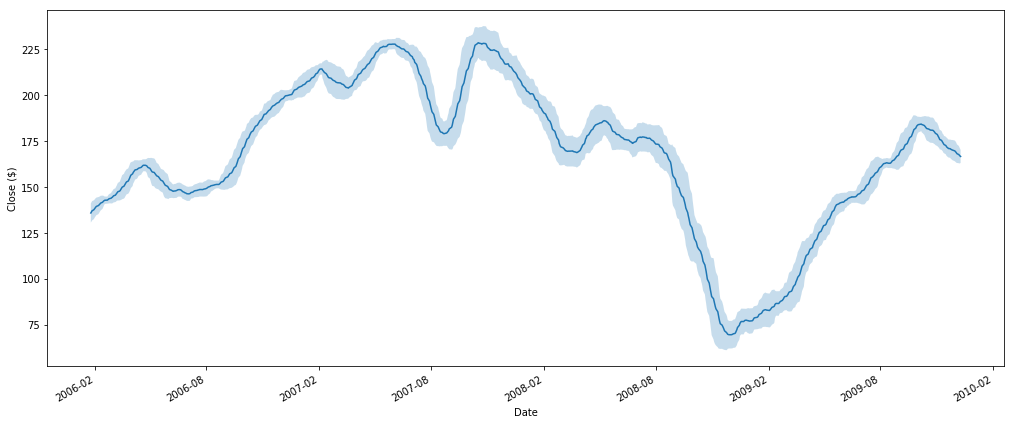

In [27]:
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot(figsize=(14, 6))
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Close ($)")

## Grab Bag

### Offsets

These are similar to `dateutil.relativedelta`, but works with arrays.

In [28]:
gs.index + pd.DateOffset(months=3, days=-2)

DatetimeIndex(['2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-07', '2006-04-08', '2006-04-09', '2006-04-10',
               '2006-04-11', '2006-04-15',
               ...
               '2010-03-15', '2010-03-16', '2010-03-19', '2010-03-20',
               '2010-03-21', '2010-03-22', '2010-03-26', '2010-03-27',
               '2010-03-28', '2010-03-29'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)

### Holiday Calendars

There are a whole bunch of special calendars, useful for traders probabaly.

In [29]:
from pandas.tseries.holiday import USColumbusDay

In [30]:
USColumbusDay.dates('2015-01-01', '2020-01-01')

DatetimeIndex(['2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',
               '2019-10-14'],
              dtype='datetime64[ns]', freq='WOM-2MON')

### Timezones

Pandas works with `pytz` for nice timezone-aware datetimes.
The typical workflow is

1. localize timezone-naive timestamps to some timezone
2. convert to desired timezone

If you already have timezone-aware Timestamps, there's no need for step one. 

In [31]:
# tz naiive -> tz aware..... to desired UTC
gs.tz_localize('US/Eastern').tz_convert('UTC').head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03 05:00:00+00:00,126.699997,129.440002,124.230003,128.869995,110.911774,6188700
2006-01-04 05:00:00+00:00,127.349998,128.910004,126.379997,127.089996,109.379845,4861600
2006-01-05 05:00:00+00:00,126.000000,127.320000,125.610001,127.040001,109.336800,3717400
2006-01-06 05:00:00+00:00,127.290001,129.250000,127.290001,128.839996,110.885956,4319600
2006-01-09 05:00:00+00:00,128.500000,130.619995,128.000000,130.389999,112.219994,4723500
